<a href="https://colab.research.google.com/github/Annie-Yeeun-Jang/dacon_timeseries/blob/main/lgbm_final/%EC%8B%9C%EA%B3%84%EC%97%B4_1%ED%8C%80_%EB%B2%A0%EC%9D%B4%EC%8A%A4%EC%BD%94%EB%93%9C_7_37.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
from google.colab import drive
from datetime import datetime, timedelta

import math
import time
import random

import lightgbm as lgb
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.externals import joblib

drive.mount('./gdrive', force_remount=True)
plt.style.use("fivethirtyeight")
plt.rc('font', family='NanumBarunGothic')
plt.rc('axes', unicode_minus=False)
warnings.filterwarnings(action='ignore')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Mounted at ./gdrive


In [ ]:
dangjin_fcst = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/투빅스/동서발전_태양광/data/fin_preprocessing/new_dangjin_fcst.csv")
ulsan_fcst = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/투빅스/동서발전_태양광/data/fin_preprocessing/new_ulsan_fcst.csv")
energy = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/투빅스/동서발전_태양광/data/fin_preprocessing/new_energy.csv")

In [ ]:
energy['time'] = pd.to_datetime(dangjin_fcst['Forecast_time'][:len(energy)])
energy['year'] = energy['time'].dt.year
energy['month'] = energy['time'].dt.month
energy['day'] = energy['time'].dt.day
energy['hour'] = energy['time'].dt.hour
energy['year-month-day'] = energy['year'].astype(str) + "-" + energy['month'].astype(str) + "-" + energy['day'].astype(str)

In [ ]:
date = dangjin_fcst['Forecast_time']

In [ ]:
dangjin_fcst['Temperature'] = dangjin_fcst['Temperature'].interpolate()
dangjin_fcst['PrecipitationForm'] = dangjin_fcst['PrecipitationForm'].interpolate()
dangjin_fcst['PrecipitationProb'] = dangjin_fcst['PrecipitationProb'].interpolate()
dangjin_fcst['Humidity'] = dangjin_fcst['Humidity'].interpolate()
dangjin_fcst['WindSpeed'] = dangjin_fcst['WindSpeed'].interpolate()
dangjin_fcst['Cloud'] = dangjin_fcst['Cloud'].interpolate()
dangjin_fcst['Precipitation'] = dangjin_fcst['Precipitation'].interpolate()
dangjin_fcst['Snow'] = dangjin_fcst['Snow'].interpolate()
#dangjin_fcst['WindDirection'] = dangjin_fcst['WindDirection'].interpolate()

ulsan_fcst['Temperature'] = ulsan_fcst['Temperature'].interpolate()
ulsan_fcst['PrecipitationForm'] = ulsan_fcst['PrecipitationForm'].interpolate()
ulsan_fcst['PrecipitationProb'] = ulsan_fcst['PrecipitationProb'].interpolate()
ulsan_fcst['Humidity'] = ulsan_fcst['Humidity'].interpolate()
ulsan_fcst['WindSpeed'] = ulsan_fcst['WindSpeed'].interpolate()
ulsan_fcst['Cloud'] = ulsan_fcst['Cloud'].interpolate()
ulsan_fcst['Precipitation'] = ulsan_fcst['Precipitation'].interpolate()
ulsan_fcst['Snow'] = ulsan_fcst['Snow'].interpolate()
#ulsan_fcst['WindDirection'] = ulsan_fcst['WindDirection'].interpolate()

In [ ]:
def angle_to_dir(x):
    if pd.isnull(x):
        return np.nan
    elif x >= 22.5 and x <67.5:
        return 'NE'
    elif x >= 67.5 and x < 112.5:
        return 'E'
    elif x >= 112.5 and x < 157.5:
        return 'SE'
    elif x >= 157.5 and x < 202.5:
        return 'S'
    elif x >= 202.5 and x < 247.5:
        return 'WS'
    elif x >= 247.5 and x < 292.5:
        return 'W'
    elif x >= 292.5 and x < 337.5:
        return 'NW'
    elif x >= 337.5 or x < 22.5:
        return 'N'

def angle_to_cos(x):
    return np.cos(np.pi/180*(x-90))
def angle_to_sin(x):
    return np.sin(np.pi/180*(x+90))

dangjin_fcst['WindDirection_x'] = dangjin_fcst['WindDirection'].apply(angle_to_cos)
dangjin_fcst['WindDirection_y'] = dangjin_fcst['WindDirection'].apply(angle_to_sin)
dangjin_fcst['Wind_x'] = dangjin_fcst['WindDirection_x'] * dangjin_fcst['WindSpeed']
dangjin_fcst['Wind_y'] = dangjin_fcst['WindDirection_y'] * dangjin_fcst['WindSpeed']

ulsan_fcst['WindDirection_x'] = ulsan_fcst['WindDirection'].apply(angle_to_cos)
ulsan_fcst['WindDirection_y'] = ulsan_fcst['WindDirection'].apply(angle_to_sin)
ulsan_fcst['Wind_x'] = ulsan_fcst['WindDirection_x'] * ulsan_fcst['WindSpeed']
ulsan_fcst['Wind_y'] = ulsan_fcst['WindDirection_y'] * ulsan_fcst['WindSpeed']


dangjin_fcst['WindDirection'] = dangjin_fcst['WindDirection'].interpolate()
ulsan_fcst['WindDirection'] = ulsan_fcst['WindDirection'].interpolate()

dangjin_fcst['WindDirection_catg'] = dangjin_fcst['WindDirection'].apply(angle_to_dir)
ulsan_fcst['WindDirection_catg'] = ulsan_fcst['WindDirection'].apply(angle_to_dir)

In [ ]:
dangjin_fcst['Wind_x'] = dangjin_fcst['Wind_x'].interpolate()
dangjin_fcst['Wind_y'] = dangjin_fcst['Wind_y'].interpolate()

ulsan_fcst['Wind_x'] = ulsan_fcst['Wind_x'].interpolate()
ulsan_fcst['Wind_y'] = ulsan_fcst['Wind_y'].interpolate()

In [ ]:
dangjin_fcst['hour'] = pd.to_datetime(dangjin_fcst['Forecast_time']).dt.hour
dangjin_fcst['day'] = pd.to_datetime(dangjin_fcst['Forecast_time']).dt.day
dangjin_fcst['month'] = pd.to_datetime(dangjin_fcst['Forecast_time']).dt.month

ulsan_fcst['hour'] = pd.to_datetime(ulsan_fcst['Forecast_time']).dt.hour
ulsan_fcst['day'] = pd.to_datetime(ulsan_fcst['Forecast_time']).dt.day
ulsan_fcst['month'] = pd.to_datetime(ulsan_fcst['Forecast_time']).dt.month

In [ ]:
b = 17.62
c = 243.12
gamma = (b * dangjin_fcst['Temperature'] /(c + dangjin_fcst['Temperature'])) + np.log(dangjin_fcst['Humidity'] / 100.0)
dewpoint = (c * gamma) / (b - gamma)
dangjin_fcst['DewPoint'] = dewpoint

gamma = (b * ulsan_fcst['Temperature'] /(c + ulsan_fcst['Temperature'])) + np.log(ulsan_fcst['Humidity'] / 100.0)
dewpoint = (c * gamma) / (b - gamma)
ulsan_fcst['DewPoint'] = dewpoint

In [ ]:
dangjin_fcst['방위각'] = dangjin_fcst['방위각'].apply(lambda x : int(x[:3]))
dangjin_fcst['고도'] = dangjin_fcst['고도'].apply(lambda x : int(x.split(" ")[0]))
dangjin_fcst['적경'] = dangjin_fcst['적경'].apply(lambda x : float(x.split(" ")[0] + "." + x.split(" ")[1] + x.split(" ")[2][:2]))
dangjin_fcst['적위'] = dangjin_fcst['적위'].apply(lambda x : float(x.split(" ")[0] + "." + x.split(" ")[1] + x.split(" ")[2][:2]))

ulsan_fcst['방위각'] = ulsan_fcst['방위각'].apply(lambda x : int(x[:3]))
ulsan_fcst['고도'] = ulsan_fcst['고도'].apply(lambda x : int(x.split(" ")[0]))
ulsan_fcst['적경'] = ulsan_fcst['적경'].apply(lambda x : float(x.split(" ")[0] + "." + x.split(" ")[1] + x.split(" ")[2][:2]))
ulsan_fcst['적위'] = ulsan_fcst['적위'].apply(lambda x : float(x.split(" ")[0] + "." + x.split(" ")[1] + x.split(" ")[2][:2]))

In [ ]:
using_col = ['Temperature', 'PrecipitationForm', 'PrecipitationProb', 'DewPoint',
             'Humidity', 'Cloud', 'Precipitation', 'Snow', 'Wind_x', 'Wind_y',
             'hour', 'month', '방위각', '고도', '적경', '적위']

dangjin_fcst = dangjin_fcst[using_col].fillna(0)
ulsan_fcst = ulsan_fcst[using_col].fillna(0)

In [ ]:
def shift(df, period):
  target = pd.DataFrame()
  for i in range(period, -1, -1):
    tmp = df.shift(i)
    target = pd.concat([target, tmp], axis = 1)
  return target

In [ ]:
dangjin_fcst = shift(dangjin_fcst, 71)
ulsan_fcst = shift(ulsan_fcst, 71)

In [ ]:
dangjin_fcst_train = dangjin_fcst.iloc[:-24 * 28]
dangjin_fcst_test = dangjin_fcst.iloc[-24 * 28:]

ulsan_fcst_train = ulsan_fcst.iloc[:-24 * 28]
ulsan_fcst_test = ulsan_fcst.iloc[-24 * 28:]

In [ ]:
energy = energy[(dangjin_fcst_train.isnull().sum(axis = 1) <= 0).values]
ulsan_fcst_train = ulsan_fcst_train[(dangjin_fcst_train.isnull().sum(axis = 1) <= 0).values]
dangjin_fcst_train = dangjin_fcst_train[(dangjin_fcst_train.isnull().sum(axis = 1) <= 0).values]

In [ ]:
dangjin_min = dangjin_fcst_train.min()
dangjin_max = dangjin_fcst_train.max()

dangjin_fcst_train = (dangjin_fcst_train - dangjin_min) / (dangjin_max - dangjin_min)
dangjin_fcst_test = (dangjin_fcst_test - dangjin_min) / (dangjin_max - dangjin_min)

In [ ]:
ulsan_min = ulsan_fcst_train.min()
ulsan_max = ulsan_fcst_train.max()

ulsan_fcst_train = (ulsan_fcst_train - ulsan_min) / (ulsan_max - ulsan_min)
ulsan_fcst_test = (ulsan_fcst_test - ulsan_min) / (ulsan_max - ulsan_min)

In [ ]:
import tensorflow as tf

In [ ]:
dangjin_fcst_train = dangjin_fcst_train.values.reshape((dangjin_fcst_train.shape[0], 72, 16, 1))
dangjin_fcst_test = dangjin_fcst_test.values.reshape((dangjin_fcst_test.shape[0], 72, 16, 1))

ulsan_fcst_train = ulsan_fcst_train.values.reshape((ulsan_fcst_train.shape[0], 72, 16, 1))
ulsan_fcst_test = ulsan_fcst_test.values.reshape((ulsan_fcst_test.shape[0], 72, 16, 1))

In [ ]:
dangjin_fcst_train = tf.image.resize(dangjin_fcst_train, (72, 32))
dangjin_fcst_test = tf.image.resize(dangjin_fcst_test, (72, 32))

ulsan_fcst_train = tf.image.resize(ulsan_fcst_train, (72, 32))
ulsan_fcst_test = tf.image.resize(ulsan_fcst_test, (72, 32))

In [ ]:
dangjin_fcst_train = np.squeeze(dangjin_fcst_train.numpy(), axis = -1)
dangjin_fcst_train = np.stack((dangjin_fcst_train,)*3, axis = -1)

dangjin_fcst_test = np.squeeze(dangjin_fcst_test.numpy(), axis = -1)
dangjin_fcst_test = np.stack((dangjin_fcst_test,)*3, axis = -1)

ulsan_fcst_train = np.squeeze(ulsan_fcst_train.numpy(), axis = -1)
ulsan_fcst_train = np.stack((ulsan_fcst_train,)*3, axis = -1)

ulsan_fcst_test = np.squeeze(ulsan_fcst_test.numpy(), axis = -1)
ulsan_fcst_test = np.stack((ulsan_fcst_test,)*3, axis = -1)

In [ ]:
def my_model():
  bottom = tf.keras.applications.EfficientNetB0(input_shape = (72, 32, 3), weights = None, include_top = False)
  model = tf.keras.models.Sequential([
                                      bottom,
                                      tf.keras.layers.GlobalAveragePooling2D(),
                                      tf.keras.layers.Dense(512, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.0001)),
                                      tf.keras.layers.Dropout(0.2),
                                      tf.keras.layers.Dense(512, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.0001)),
                                      tf.keras.layers.Dropout(0.2),
                                      tf.keras.layers.Dense(1)
  ])
  return model

In [ ]:
"""
def my_model():
  input = tf.keras.Input(shape = (26, 24))
  x = tf.keras.layers.LSTM(32, return_sequences = True)(input)
  x = tf.keras.layers.LSTM(32, return_sequences = True)(x)
  x = tf.keras.layers.LSTM(16, return_sequences = True)(x)
  x = tf.keras.layers.LSTM(16, return_sequences = False)(x)
  x = tf.keras.layers.LSTM(8, return_sequences = False)(x)
  x = tf.keras.layers.LSTM(8, return_sequences = False)(x)
  x = tf.keras.layers.Dense(16, activation = 'relu')(x)
  x = tf.keras.layers.Dense(8, activation = 'relu')(x)
  x = tf.keras.layers.Dense(8, activation = 'relu')(x)
  x = tf.keras.layers.Dense(1, activation = 'relu')(x)
  model = tf.keras.models.Model(inputs = input, outputs = x)
  return model
"""

"\ndef my_model():\n  input = tf.keras.Input(shape = (26, 24))\n  x = tf.keras.layers.LSTM(32, return_sequences = True)(input)\n  x = tf.keras.layers.LSTM(32, return_sequences = True)(x)\n  x = tf.keras.layers.LSTM(16, return_sequences = True)(x)\n  x = tf.keras.layers.LSTM(16, return_sequences = False)(x)\n  x = tf.keras.layers.LSTM(8, return_sequences = False)(x)\n  x = tf.keras.layers.LSTM(8, return_sequences = False)(x)\n  x = tf.keras.layers.Dense(16, activation = 'relu')(x)\n  x = tf.keras.layers.Dense(8, activation = 'relu')(x)\n  x = tf.keras.layers.Dense(8, activation = 'relu')(x)\n  x = tf.keras.layers.Dense(1, activation = 'relu')(x)\n  model = tf.keras.models.Model(inputs = input, outputs = x)\n  return model\n"

In [ ]:
def make_dataset(df, col):
  X = df[energy[col].notnull() & energy[col]!=0]
  y = energy[energy[col].notnull() & energy[col]!=0]

  tmp = y.groupby(['year', 'month', 'day']).mean()
  tmp = tmp.query("%s == 0"%col).reset_index()
  tmp['year-month-day'] = tmp['year'].astype(str) + "-" + tmp['month'].astype(str) + "-" + tmp['day'].astype(str)

  X = X[~y['year-month-day'].isin(tmp['year-month-day'])]
  y = y[~y['year-month-day'].isin(tmp['year-month-day'])][col]
  return X, y.values

In [ ]:
floating_X, floating_y = make_dataset(dangjin_fcst_train, "dangjin_floating")

In [ ]:
BATCH_SIZE = 64
kfold = KFold(n_splits = 5, shuffle = True, random_state = 509)
for i, (train_idx, val_idx) in enumerate(kfold.split(floating_X, floating_y)):

  X_train, X_val = floating_X[train_idx], floating_X[val_idx]
  y_train, y_val = floating_y[train_idx], floating_y[val_idx]
  
  model_path = '/content/gdrive/MyDrive/Colab Notebooks/투빅스/동서발전_태양광/model/floating_fold%s.h5'%i
  model = my_model()
  model.compile(optimizer = "adam", loss = "mse", metrics = ["mae"])
  model.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = 100, validation_data = (X_val, y_val),
                      callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath = model_path, monitor = 'val_mae', save_best_only = True, mode = 'min'),
                                   tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_mae', factor = 0.5, patience = 7)])

Epoch 1/100
166/166 [==============================] - 17s 60ms/step - loss: 21488.3008 - mae: 102.7510 - val_loss: 45244.2500 - val_mae: 180.5211
Epoch 2/100
166/166 [==============================] - 9s 54ms/step - loss: 10987.5381 - mae: 74.8083 - val_loss: 43976.6484 - val_mae: 179.4125
Epoch 3/100
166/166 [==============================] - 9s 54ms/step - loss: 9818.1250 - mae: 70.2524 - val_loss: 34384.5820 - val_mae: 156.0861
Epoch 4/100
166/166 [==============================] - 9s 54ms/step - loss: 8588.6904 - mae: 65.1252 - val_loss: 15350.5117 - val_mae: 97.9884
Epoch 5/100
166/166 [==============================] - 9s 54ms/step - loss: 7784.1045 - mae: 62.2760 - val_loss: 11457.7617 - val_mae: 75.5146
Epoch 6/100
166/166 [==============================] - 9s 54ms/step - loss: 7467.3804 - mae: 60.1155 - val_loss: 9523.0518 - val_mae: 72.6830
Epoch 7/100
166/166 [==============================] - 9s 54ms/step - loss: 6364.0532 - mae: 56.3644 - val_loss: 8190.6191 - val_mae: 62

In [ ]:
warehouse_X, warehouse_y = make_dataset(dangjin_fcst_train, "dangjin_warehouse")

In [ ]:
BATCH_SIZE = 64
kfold = KFold(n_splits = 5, shuffle = True, random_state = 509)
for i, (train_idx, val_idx) in enumerate(kfold.split(warehouse_X, warehouse_y)):

  X_train, X_val = warehouse_X[train_idx], warehouse_X[val_idx]
  y_train, y_val = warehouse_y[train_idx], warehouse_y[val_idx]
  
  model_path = '/content/gdrive/MyDrive/Colab Notebooks/투빅스/동서발전_태양광/model/warehouse_fold%s.h5'%i
  model = my_model()
  model.compile(optimizer = "adam", loss = "mse", metrics = ["mae"])
  model.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = 100, validation_data = (X_val, y_val),
                      callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath = model_path, monitor = 'val_mae', save_best_only = True, mode = 'min'),
                                   tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_mae', factor = 0.5, patience = 7)])

Epoch 1/100
217/217 [==============================] - 20s 60ms/step - loss: 12227.6387 - mae: 79.0123 - val_loss: 28450.7695 - val_mae: 137.6342
Epoch 2/100
217/217 [==============================] - 12s 56ms/step - loss: 7002.4146 - mae: 60.5702 - val_loss: 27641.9375 - val_mae: 134.1332
Epoch 3/100
217/217 [==============================] - 12s 57ms/step - loss: 6188.2827 - mae: 56.1596 - val_loss: 11515.9541 - val_mae: 87.8500
Epoch 4/100
217/217 [==============================] - 12s 54ms/step - loss: 5475.6934 - mae: 52.6169 - val_loss: 5290.5688 - val_mae: 50.9439
Epoch 5/100
217/217 [==============================] - 12s 54ms/step - loss: 5105.0654 - mae: 50.6621 - val_loss: 5498.4102 - val_mae: 51.6757
Epoch 6/100
217/217 [==============================] - 12s 53ms/step - loss: 4655.9805 - mae: 48.2768 - val_loss: 7828.1582 - val_mae: 61.6977
Epoch 7/100
217/217 [==============================] - 12s 53ms/step - loss: 4111.9653 - mae: 45.3144 - val_loss: 5399.8433 - val_mae: 5

In [ ]:
dangjin_X, dangjin_y = make_dataset(dangjin_fcst_train, "dangjin")

In [ ]:
BATCH_SIZE = 64
kfold = KFold(n_splits = 5, shuffle = True, random_state = 509)
for i, (train_idx, val_idx) in enumerate(kfold.split(dangjin_X, dangjin_y)):

  X_train, X_val = dangjin_X[train_idx], dangjin_X[val_idx]
  y_train, y_val = dangjin_y[train_idx], dangjin_y[val_idx]
  
  model_path = '/content/gdrive/MyDrive/Colab Notebooks/투빅스/동서발전_태양광/model/dangjin_fold%s.h5'%i
  model = my_model()
  model.compile(optimizer = "adam", loss = "mse", metrics = ["mae"])
  model.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = 100, validation_data = (X_val, y_val),
                      callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath = model_path, monitor = 'val_mae', save_best_only = True, mode = 'min'),
                                   tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_mae', factor = 0.5, patience = 7)])

Epoch 1/100
206/206 [==============================] - 53s 71ms/step - loss: 27666.6211 - mae: 120.9365 - val_loss: 71839.0000 - val_mae: 213.8459
Epoch 2/100
206/206 [==============================] - 13s 61ms/step - loss: 15285.6709 - mae: 91.1319 - val_loss: 85233.4297 - val_mae: 225.8003
Epoch 3/100
206/206 [==============================] - 13s 63ms/step - loss: 14246.6689 - mae: 87.5090 - val_loss: 46482.2227 - val_mae: 173.7285
Epoch 4/100
206/206 [==============================] - 13s 64ms/step - loss: 12361.2129 - mae: 81.3098 - val_loss: 15332.6211 - val_mae: 86.4664
Epoch 5/100
206/206 [==============================] - 13s 64ms/step - loss: 11265.9639 - mae: 77.4808 - val_loss: 12905.5967 - val_mae: 84.9367
Epoch 6/100
206/206 [==============================] - 13s 61ms/step - loss: 10410.4609 - mae: 74.2576 - val_loss: 20835.7480 - val_mae: 104.3176
Epoch 7/100
206/206 [==============================] - 12s 59ms/step - loss: 9041.6348 - mae: 69.4554 - val_loss: 16665.0352 

In [ ]:
ulsan_X, ulsan_y = make_dataset(ulsan_fcst_train, "ulsan")

In [ ]:
BATCH_SIZE = 64
kfold = KFold(n_splits = 5, shuffle = True, random_state = 509)
for i, (train_idx, val_idx) in enumerate(kfold.split(ulsan_X, ulsan_y)):

  X_train, X_val = ulsan_X[train_idx], ulsan_X[val_idx]
  y_train, y_val = ulsan_y[train_idx], ulsan_y[val_idx]
  
  model_path = '/content/gdrive/MyDrive/Colab Notebooks/투빅스/동서발전_태양광/model/ulsan_fold%s.h5'%i
  model = my_model()
  model.compile(optimizer = "adam", loss = "mse", metrics = ["mae"])
  model.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = 100, validation_data = (X_val, y_val),
                      callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath = model_path, monitor = 'val_mae', save_best_only = True, mode = 'min'),
                                   tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_mae', factor = 0.5, patience = 7)])

Epoch 1/100
213/213 [==============================] - 23s 72ms/step - loss: 5419.8599 - mae: 52.4698 - val_loss: 16060.7549 - val_mae: 101.3913
Epoch 2/100
213/213 [==============================] - 14s 64ms/step - loss: 3248.3108 - mae: 41.4579 - val_loss: 17076.3574 - val_mae: 102.3087
Epoch 3/100
213/213 [==============================] - 13s 59ms/step - loss: 2626.0830 - mae: 36.8319 - val_loss: 6148.6338 - val_mae: 62.6874
Epoch 4/100
213/213 [==============================] - 13s 60ms/step - loss: 2628.7944 - mae: 36.9664 - val_loss: 2476.9009 - val_mae: 35.2435
Epoch 5/100
213/213 [==============================] - 13s 60ms/step - loss: 2237.9351 - mae: 33.6503 - val_loss: 2464.8340 - val_mae: 35.1612
Epoch 6/100
213/213 [==============================] - 13s 60ms/step - loss: 1994.9825 - mae: 31.8318 - val_loss: 2149.7410 - val_mae: 31.4047
Epoch 7/100
213/213 [==============================] - 13s 60ms/step - loss: 1861.6171 - mae: 30.6138 - val_loss: 2028.8342 - val_mae: 32.

In [ ]:
floating_model0 = tf.keras.models.load_model("/content/gdrive/MyDrive/Colab Notebooks/투빅스/동서발전_태양광/model/floating_fold0.h5")
floating_model1 = tf.keras.models.load_model("/content/gdrive/MyDrive/Colab Notebooks/투빅스/동서발전_태양광/model/floating_fold1.h5")
floating_model2 = tf.keras.models.load_model("/content/gdrive/MyDrive/Colab Notebooks/투빅스/동서발전_태양광/model/floating_fold2.h5")
floating_model3 = tf.keras.models.load_model("/content/gdrive/MyDrive/Colab Notebooks/투빅스/동서발전_태양광/model/floating_fold3.h5")
floating_model4 = tf.keras.models.load_model("/content/gdrive/MyDrive/Colab Notebooks/투빅스/동서발전_태양광/model/floating_fold4.h5")

In [ ]:
floating0 = floating_model0.predict(dangjin_fcst_test)
floating1 = floating_model1.predict(dangjin_fcst_test)
floating2 = floating_model2.predict(dangjin_fcst_test)
floating3 = floating_model3.predict(dangjin_fcst_test)
floating4 = floating_model4.predict(dangjin_fcst_test)

In [ ]:
warehouse_model0 = tf.keras.models.load_model("/content/gdrive/MyDrive/Colab Notebooks/투빅스/동서발전_태양광/model/warehouse_fold0.h5")
warehouse_model1 = tf.keras.models.load_model("/content/gdrive/MyDrive/Colab Notebooks/투빅스/동서발전_태양광/model/warehouse_fold1.h5")
warehouse_model2 = tf.keras.models.load_model("/content/gdrive/MyDrive/Colab Notebooks/투빅스/동서발전_태양광/model/warehouse_fold2.h5")
warehouse_model3 = tf.keras.models.load_model("/content/gdrive/MyDrive/Colab Notebooks/투빅스/동서발전_태양광/model/warehouse_fold3.h5")
warehouse_model4 = tf.keras.models.load_model("/content/gdrive/MyDrive/Colab Notebooks/투빅스/동서발전_태양광/model/warehouse_fold4.h5")

In [ ]:
warehouse0 = warehouse_model0.predict(dangjin_fcst_test)
warehouse1 = warehouse_model1.predict(dangjin_fcst_test)
warehouse2 = warehouse_model2.predict(dangjin_fcst_test)
warehouse3 = warehouse_model3.predict(dangjin_fcst_test)
warehouse4 = warehouse_model4.predict(dangjin_fcst_test)

In [ ]:
dangjin_model0 = tf.keras.models.load_model("/content/gdrive/MyDrive/Colab Notebooks/투빅스/동서발전_태양광/model/dangjin_fold0.h5")
dangjin_model1 = tf.keras.models.load_model("/content/gdrive/MyDrive/Colab Notebooks/투빅스/동서발전_태양광/model/dangjin_fold1.h5")
dangjin_model2 = tf.keras.models.load_model("/content/gdrive/MyDrive/Colab Notebooks/투빅스/동서발전_태양광/model/dangjin_fold2.h5")
dangjin_model3 = tf.keras.models.load_model("/content/gdrive/MyDrive/Colab Notebooks/투빅스/동서발전_태양광/model/dangjin_fold3.h5")
dangjin_model4 = tf.keras.models.load_model("/content/gdrive/MyDrive/Colab Notebooks/투빅스/동서발전_태양광/model/dangjin_fold4.h5")

In [ ]:
dangjin0 = dangjin_model0.predict(dangjin_fcst_test)
dangjin1 = dangjin_model1.predict(dangjin_fcst_test)
dangjin2 = dangjin_model2.predict(dangjin_fcst_test)
dangjin3 = dangjin_model3.predict(dangjin_fcst_test)
dangjin4 = dangjin_model4.predict(dangjin_fcst_test)

In [ ]:
ulsan_model0 = tf.keras.models.load_model("/content/gdrive/MyDrive/Colab Notebooks/투빅스/동서발전_태양광/model/ulsan_fold0.h5")
ulsan_model1 = tf.keras.models.load_model("/content/gdrive/MyDrive/Colab Notebooks/투빅스/동서발전_태양광/model/ulsan_fold1.h5")
ulsan_model2 = tf.keras.models.load_model("/content/gdrive/MyDrive/Colab Notebooks/투빅스/동서발전_태양광/model/ulsan_fold2.h5")
ulsan_model3 = tf.keras.models.load_model("/content/gdrive/MyDrive/Colab Notebooks/투빅스/동서발전_태양광/model/ulsan_fold3.h5")
ulsan_model4 = tf.keras.models.load_model("/content/gdrive/MyDrive/Colab Notebooks/투빅스/동서발전_태양광/model/ulsan_fold4.h5")

In [ ]:
ulsan0 = ulsan_model0.predict(ulsan_fcst_test)
ulsan1 = ulsan_model1.predict(ulsan_fcst_test)
ulsan2 = ulsan_model2.predict(ulsan_fcst_test)
ulsan3 = ulsan_model3.predict(ulsan_fcst_test)
ulsan4 = ulsan_model4.predict(ulsan_fcst_test)

In [ ]:
floating = (floating0 + floating1 + floating2 + floating3 + floating4) / 5
warehouse = (warehouse0 + warehouse1 + warehouse2 + warehouse3 + warehouse4) / 5
dangjin = (dangjin0 + dangjin1 + dangjin2 + dangjin3 + dangjin4) / 5
ulsan = (ulsan0 + ulsan1 + ulsan2 + ulsan3 + ulsan4) / 5

In [ ]:
sample_submission = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/투빅스/동서발전_태양광/data/sample_submission.csv")

In [ ]:
sample_submission.loc[:671, 'dangjin_floating'] = floating
sample_submission.loc[:671, 'dangjin_warehouse'] = warehouse
sample_submission.loc[:671, 'dangjin'] = dangjin
sample_submission.loc[:671, 'ulsan'] = ulsan

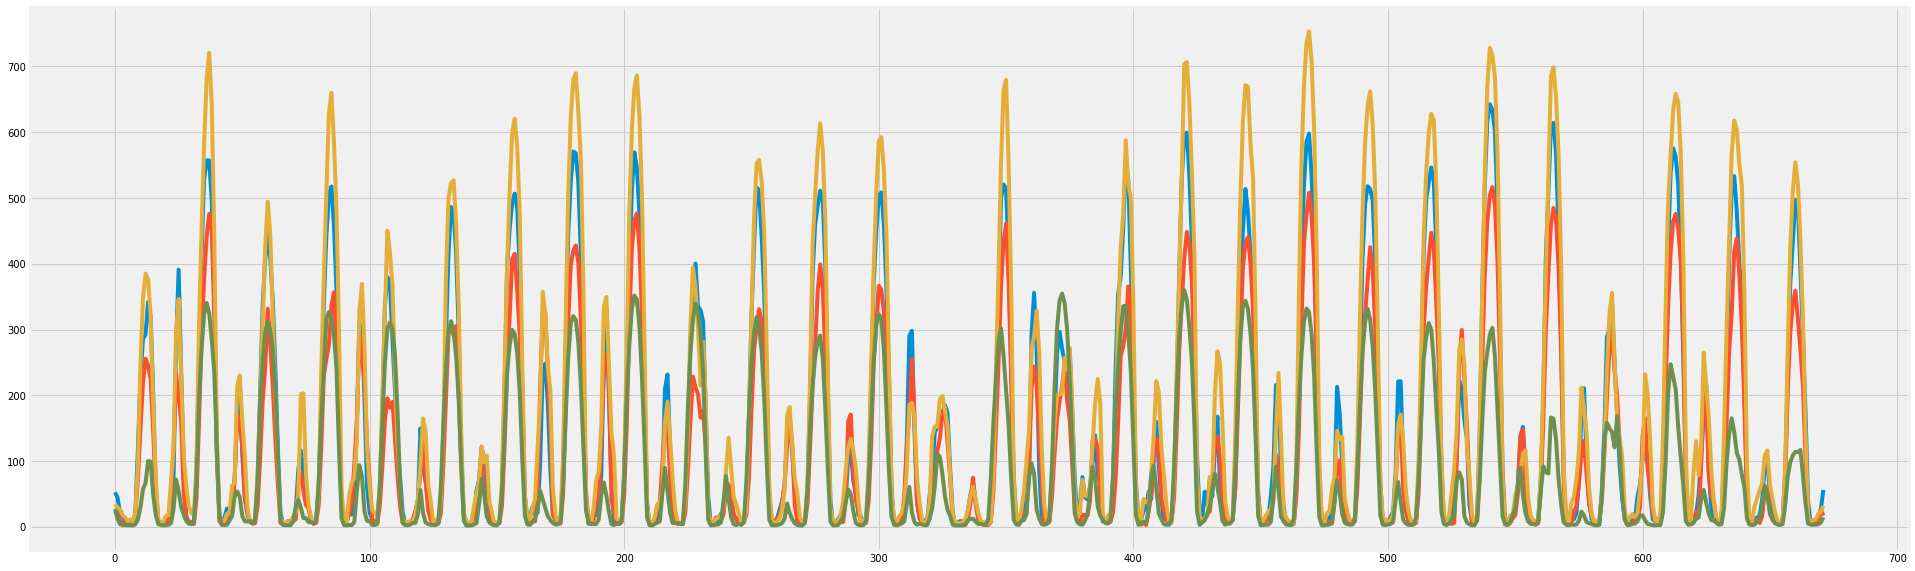

In [ ]:
# notzero
plt.figure(figsize = (30, 10))
plt.plot(sample_submission['dangjin_floating'][:672])
plt.plot(sample_submission['dangjin_warehouse'][:672])
plt.plot(sample_submission['dangjin'][:672])
plt.plot(sample_submission['ulsan'][:672])

In [ ]:
sample_submission.to_csv("/content/gdrive/MyDrive/Colab Notebooks/투빅스/동서발전_태양광/submission/0531_cnn_5fold.csv", index = False)

#-----------------------------------------------------------

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def make_dataset(df, col):
  X = df[energy[col].notnull() & energy[col]!=0]
  y = energy[energy[col].notnull() & energy[col]!=0]

  tmp = y.groupby(['year', 'month', 'day']).mean()
  tmp = tmp.query("%s == 0"%col).reset_index()
  tmp['year-month-day'] = tmp['year'].astype(str) + "-" + tmp['month'].astype(str) + "-" + tmp['day'].astype(str)

  X = X[~y['year-month-day'].isin(tmp['year-month-day'])]
  y = y[~y['year-month-day'].isin(tmp['year-month-day'])][col]
  return torch.tensor(X.values, dtype = torch.float32), torch.tensor(y.values, dtype = torch.float32)

In [ ]:
def fit(epoch, model, data_loader, optimizer, criterion, phase = 'training'):
  if phase == 'training':
    model.train()
  elif phase == 'validation':
    model.eval()
  
  running_loss = 0
  running_mae = 0

  total_batch = len(data_loader)

  for batch_idx, (data, target) in enumerate(data_loader):
    if phase == 'training':
      optimizer.zero_grad()
    
    data, target = data.to(device), target.to(device)
    output = model(data)
    
    loss = criterion(output, target)
    mae = F.l1_loss(output, target)

    if phase == 'training':
      loss.backward()
      optimizer.step()
    
    running_loss += loss / total_batch
    running_mae += mae / total_batch
  
  print('[Epoch: {:>4}] \t{}_loss = {:>.9} \t{}_mae = {:>.9}'.format(epoch + 1, phase, running_loss, phase, running_mae))
  
  return running_loss, running_mae

# floating

In [ ]:
X = dangjin_fcst_train[energy[col].notnull() & energy[col]==0]
y = energy[energy[col].notnull() & energy[col]==0]

In [ ]:
floating_X.shape

torch.Size([9480, 26])

In [ ]:
def save_checkpoint(epoch, model, optimizer, filename):
  state = {
      'Epoch' : epoch,
      'State_dict' : model.state_dict(),
      'optimizer' : optimizer.state_dict()
  }
  torch.save(state, filename)

In [ ]:
BATCH_SIZE = 128
kfold = KFold(n_splits = 5, shuffle = True, random_state = 509)
for i, (train_idx, val_idx) in enumerate(kfold.split(floating_X, floating_y)):

  X_train, X_val = floating_X[train_idx], floating_X[val_idx]
  y_train, y_val = floating_y[train_idx], floating_y[val_idx]

  train_data = TensorDataset(X_train, y_train)
  val_data = TensorDataset(X_val, y_val)

  train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)
  val_loader = DataLoader(val_data, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)

  model = Model().to(device)
  
  criterion = nn.MSELoss().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
  #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5, patience = 7)

  val_mae = [10000]
  PATH = '/content/gdrive/MyDrive/Colab Notebooks/투빅스/동서발전_태양광/model/floating_fold%s.pt'%i

  for epoch in range(150):

    epoch_loss, epoch_mae = fit(epoch, model, train_loader, optimizer, criterion, 'training')
    val_epoch_loss, val_epoch_mae = fit(epoch, model, val_loader, optimizer, criterion, 'validation')
    #scheduler.step(val_epoch_mae)

    val_mae.append(val_epoch_mae)
    if val_epoch_mae < min(val_mae[:-1]):
      save_checkpoint(epoch + 1, model, optimizer, PATH)

  print("THE BEST MAE OF THIS FOLD IS %s"%max(val_accuracy))

[Epoch:    1] 	training_loss = nan 	training_mae = nan
[Epoch:    1] 	validation_loss = nan 	validation_mae = nan
[Epoch:    2] 	training_loss = nan 	training_mae = nan
[Epoch:    2] 	validation_loss = nan 	validation_mae = nan
[Epoch:    3] 	training_loss = nan 	training_mae = nan
[Epoch:    3] 	validation_loss = nan 	validation_mae = nan


KeyboardInterrupt: ignored

In [ ]:
x, y = next(iter(train_loader))

In [ ]:
yhat = model(x)

In [ ]:
torch.abs(y - yhat.view_as(y)).mean()

tensor(118.8162, grad_fn=<MeanBackward0>)

In [ ]:
criterion = nn.MSELoss()

In [ ]:
loss = criterion(y, yhat.view_as(y))

In [ ]:
loss

tensor(52138.9961, grad_fn=<MseLossBackward>)

In [ ]:
((y - yhat.view_as(y)) ** 2).mean()

tensor(52138.9961, grad_fn=<MeanBackward0>)